In [107]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim
from scipy import fft

# 変圧器

## (1) 抵抗測定

四端子法で1次(primary)、2次(secondary)の電圧、電流を測定

$r=R\frac{234.5+T}{234.5+t}$

In [108]:
# I_p = 1
# V_p = 1
# I_s = 1
# V_s = 1
# temp = 24.0
# R_p = V_p / I_p
# R_s = V_s / I_s

R_p = 0.265
R_s = 0.051
temp = 19

r_p = lambda T: R_p * (234.5 + T)/(234.5 + temp)
r_s = lambda T: R_s * (234.5 + T)/(234.5 + temp)

## (2) 無負荷試験・短絡試験

### 無負荷試験

**1次側：定格電圧**

電流$\dot{I}$、電圧$\dot{V}$、電力の実効値$\dot{P}$、位相差$\theta$($V$基準)が与えられている。

アドミタンス$Y_0=G_0+jB_0=|Y_0|e^{j\theta}$。

$I = Y_0V = |Y_0|e^{j\theta}V$

$\therefore |Y_0| = \sqrt{G_0^2 + B_0^2} = \frac{\dot{I}}{\dot{V}}$

$\dot{P} = \text{Re}(IV)=\dot{I}\dot{V}\cos{\theta}$

$\text{Re}\,Y_0 = G_0 = \frac{\dot{P}}{\dot{V}^2}$

$B_0$は$\omega$依存？

In [109]:
# 解放の測定
I_open = 0.5568
V_open = 200.24
P_open = 26.1
phase_open = 0 #radian

#
print(f"P (measured) = {P_open}")
print(f"P = IVcosΘ = {I_open*V_open*np.cos(phase_open): .2f}")

G_0 = P_open / V_open**2
B_0 = -np.sqrt((I_open/V_open)**2 - G_0**2)
Y_0 = G_0 + 1j * B_0

print(f"G_0 = {G_0 : .2e}")
print(f"B_0 = {B_0 : .2e}")
print(f"Y_0 = {Y_0 : .2e}")

P (measured) = 26.1
P = IVcosΘ =  111.49
G_0 =  6.51e-04
B_0 = -2.70e-03
Y_0 =  6.51e-04-2.70e-03j


### 短絡試験

**2次側：定格電流** (小電圧・電流)

電流$\dot{I}$、電圧$\dot{V}$、電力の実効値$\dot{P}$、位相差$\theta$($I$基準)が与えられている。

インピーダンス$Z_1=R_1+jX_1=|Z_1|e^{j\theta}$。

$V = Z_1I = |Z_1|e^{j\theta}I$

$\therefore |Z_1| = \sqrt{R_1^2 + X_1^2} = \frac{\dot{V}}{\dot{I}}$

$\dot{P} = \text{Re}(IV)=\dot{I}\dot{V}\cos{\theta}$

$\text{Re}\,Z_1 = R_1 = \frac{\dot{P}}{\dot{I}^2}$

$B_0$は$\omega$依存？

In [110]:
# 短絡の測定
I_short = 10.077
V_short = 6.57
P_short = 55.7
phase_short = 0

#
print(f"P (measured) = {P_short}")
print(f"P = IVcosΘ = {I_short*V_short*np.cos(phase_short): .2f}")

R_1 = P_short/I_short**2
X_1 = np.sqrt((V_short/I_short)**2 - R_1**2)
Z_1 = R_1 + 1j * X_1

print(f"R_1 = {R_1 : .2f}")
print(f"R_theory @75℃ = {r_p(75) + 0.5**2 * r_s(75): .2f}")
print(f"X_1 = {X_1 : .2f}")
print(f"Z_1 = {Z_1 : .2f}")

P (measured) = 55.7
P = IVcosΘ =  66.21
R_1 =  0.55
R_theory @75℃ =  0.34
X_1 =  0.35
Z_1 =  0.55+0.35j


## (3) 負荷試験

In [111]:
df_trans = pd.read_csv("data_trans.csv")
df_trans

efficiency = lambda P0, pf, c, Wi, Wc: P0*pf*c / (P0*pf*c + Wi + Wc * c**2) * 100

電圧変動率
$\epsilon = \frac{V_{20} - V_{2n}}{V_{2n}} \times100$

In [112]:
e = (df_trans.iloc[0]["V2"] - df_trans.iloc[-1]["V2"]) / df_trans.iloc[-1]["V2"] * 100
print(f"Change rate = {e:.2f}%")

Change rate = 4.03%


**1次側：定格電圧**

$\eta_C = \frac{\text{出力}}{\text{出力} +\text{損失}} \times 100 = \frac{P_0\times pf\times c}{P_0\times pf\times c + W_i + W_c\times c^2}\times 100$

Where $P_0$: 定格出力、$pf$: 負荷力率、$c: \frac{\text{負荷電流}}{\text{定格電流}}$、$W_i$: 定格電圧における鉄損、$W_c$: 定格電流における銅損


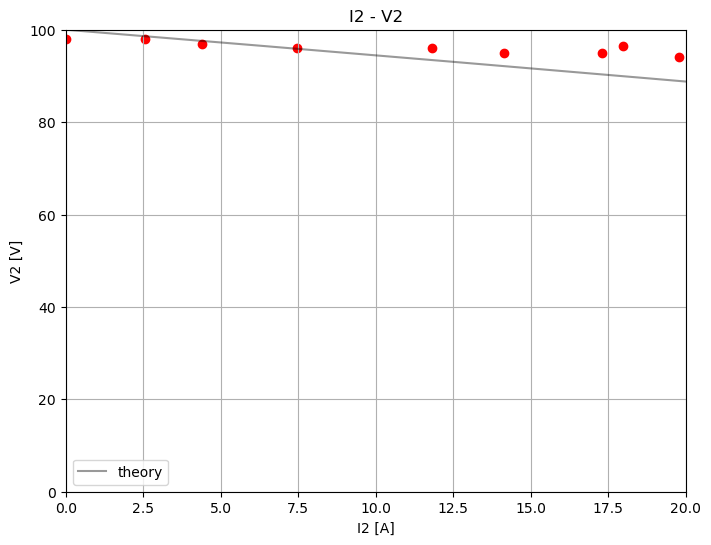

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
axessetting = AxesSetting(legend=True, xlabel="I2 [A]", ylabel="V2 [V]", grid="both", xlim=(0, 20), title="I2 - V2", ylim=(0, 100))
Wi = G_0 * 200 ** 2
Wc = P_short
axessetting.plot_func(ax, lambda I2: (-R_1*I2*2 + np.sqrt(200**2 - X_1**2 * (I2*2)**2)) / 2, label="theory", c="black", alpha=0.4)
ax.scatter(df_trans["I2"], df_trans["V2"], c="red")
axessetting.apply_axes(ax)

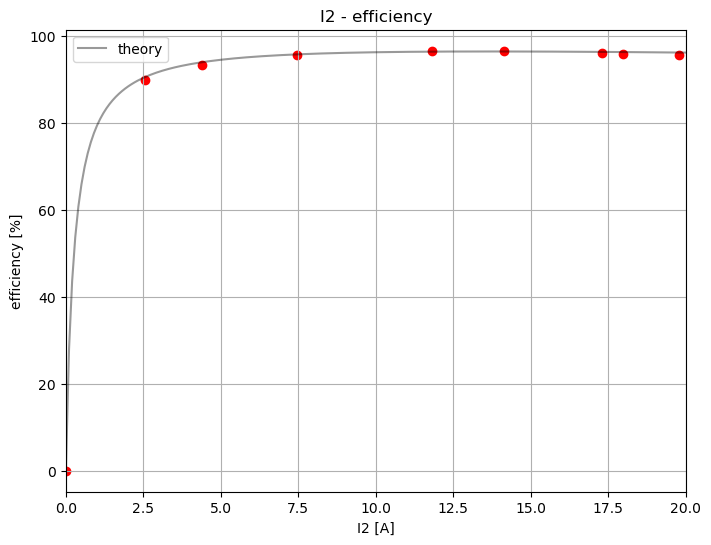

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
axessetting = AxesSetting(legend=True, xlabel="I2 [A]", ylabel="efficiency [%]", grid="both", xlim=(0, 20), title="I2 - efficiency")
Wi = G_0 * 200 ** 2
Wc = P_short
axessetting.plot_func(ax, lambda I2: efficiency(2000, 1, I2/20, Wi, Wc), label="theory", c="black", alpha=0.4)
ax.scatter(df_trans["I2"], df_trans["P2"]/df_trans["P1"]*100, c="red")
axessetting.apply_axes(ax)

In [115]:
# 無負荷試験
df_ns_1 = pd.read_csv("ALL0008/F0008CH1.CSV", usecols=[3, 4], header=None, names=["t", "V1"])
df_ns_2 = pd.read_csv("ALL0008/F0008CH2.CSV", usecols=[3, 4], header=None, names=["t", "I1"])
df_ns = df_ns_1.merge(df_ns_2, on="t")
df_ns = df_ns[(df_ns["t"] >= -0.02) & (df_ns["t"] < 0.02)]
df_ns

,t,V1,I1
255,-0.02000,260.0,0.28
256,-0.01998,260.0,0.24
257,-0.01996,260.0,0.32
258,-0.01994,260.0,0.28
259,-0.01992,260.0,0.28
...,...,...,...
2250,0.01990,264.0,0.28
2251,0.01992,260.0,0.24
2252,0.01994,260.0,0.28
2253,0.01996,260.0,0.24


In [116]:
V1_real = np.sqrt(np.mean(df_ns["V1"]**2))
I1_real = np.sqrt(np.mean(df_ns["I1"]**2))
P1_real = np.mean(df_ns["V1"] * df_ns["I1"])
print(f"{V1_real =}, {I1_real =}, {P1_real =}")

V1_real =204.1036991335532, I1_real =0.5952397836166532, P1_real =27.32008


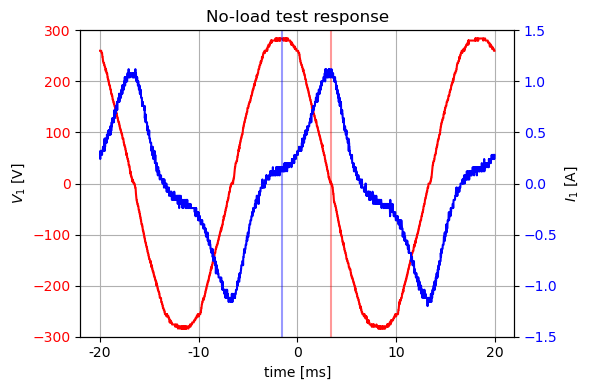

In [117]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.set_title("No-load test response")
ax1.set_xticks(np.arange(-0.02, 0.03, 0.01))
ax1.set_xticklabels(np.arange(-20, 30, 10))
ax1.grid(visible=True, which="both", axis="both")
ax1.set_ylim(-300, 300)
ax1.plot(df_ns["t"], df_ns["V1"], label="$V_1$", c="red")
ax1.set_xlabel("time [ms]")
ax1.set_ylabel("$V_1$ [V]")
ax1.tick_params(axis="y", labelcolor="red")
ax1.axvline(3.4e-3, alpha=0.4, c="red", label=f"vert")
ax1.axvline(-1.6e-3, alpha=0.4, c="blue", label=f"vert")
ax2 = ax1.twinx()
ax2.set_ylim(-1.5, 1.5)
ax2.plot(df_ns["t"], df_ns["I1"], label="I1", c="blue")
ax2.set_ylabel("$I_1$ [A]")
ax2.tick_params(axis="y", labelcolor="blue")
fig.tight_layout()


fftY =  6.54e-04-2.67e-03j, np.abs(fftY) = 0.0027473320024796384, np.angle(fftY, deg=True) = -76.22075593999867


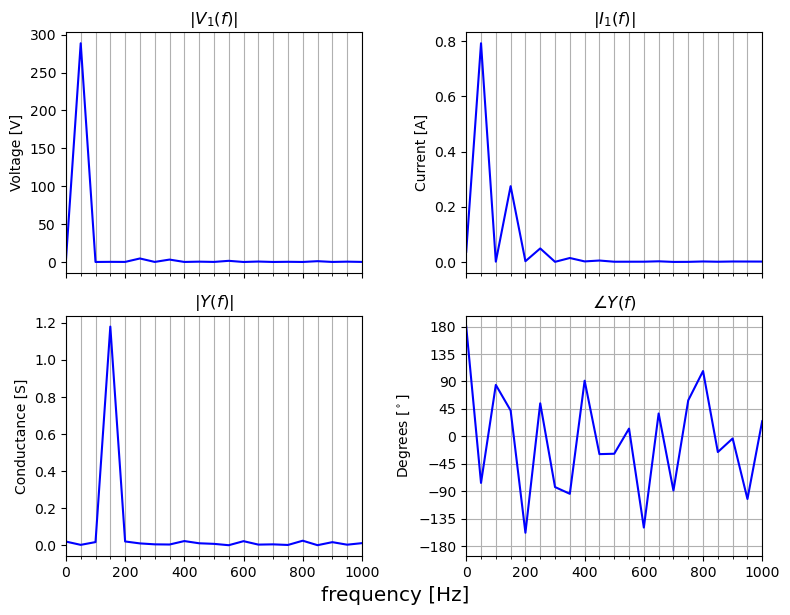

In [118]:
# RFFT
fft_v = (fft.rfft(df_ns["V1"].to_numpy())/1000)[0::2]
fft_i = (fft.rfft(df_ns["I1"].to_numpy())/1000)[0::2]
freq = fft.rfftfreq(len(df_ns["V1"]), 2e-5)[0::2]
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=False)

ax[0,0].set_xlim(0, 1000)
ax[0,0].set_xticks(np.arange(0, 1001, 50), minor=True)
ax[0,0].grid(visible=True, which="both", axis="x")
ax[0,0].set_ylabel("Voltage [V]")
ax[0,0].set_title("$|V_1(f)|$")
ax[0,0].plot(freq, np.abs(fft_v), c="blue")

ax[0,1].grid(visible=True, which="both", axis="x")
ax[0,1].set_ylabel("Current [A]")
ax[0,1].set_title("$|I_1(f)|$")
ax[0,1].plot(freq, np.abs(fft_i), c="blue")

ax[1,0].grid(visible=True, which="both", axis="x")
ax[1,0].set_ylabel("Conductance [S]")
ax[1,0].set_title("$|Y(f)|$")
ax[1,0].plot(freq, np.abs(fft_i/fft_v), c="blue")

ax[1,1].grid(visible=True, which="both", axis="both")
ax[1,1].set_ylabel("Degrees [$^\\circ$]")
ax[1,1].set_title("$\\angle Y(f)$")
ax[1,1].plot(freq, np.angle(fft_i/fft_v, deg=True), c="blue")
ax[1,1].set_yticks(np.arange(-180, 181, 45))
fig.text(0.5, -0.01, "frequency [Hz]", ha="center", fontsize="x-large")
fig.tight_layout()

fftY = (fft_i/fft_v)[1]
print(f"{fftY = : .2e}, {np.abs(fftY) = }, {np.angle(fftY, deg=True) = }")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


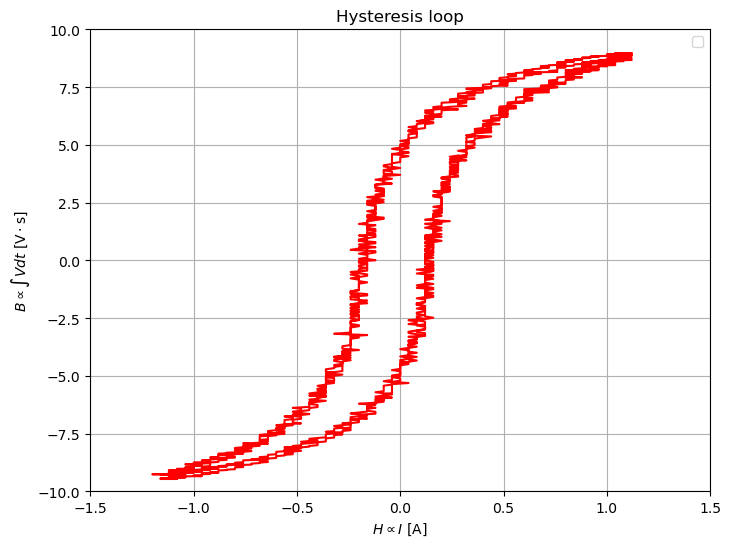

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
df_ns["B"] = df_ns["V1"] * 0.0002
for i in range(1, len(df_ns)):
    df_ns["B"].iloc[i] += df_ns["B"].iloc[i-1]
# Offset
df_ns["B"] -= df_ns[df_ns["t"] == -1.6e-3].iloc[0]["B"]
axessetting = AxesSetting(legend=True, xlabel="$H \propto I$ [A]", ylabel="$B\propto \int Vdt$ [$\\text{V}\cdot \\text{s}$]", grid="both", xlim=(-1.5, 1.5), title="Hysteresis loop", ylim=(-10, 10))
ax.plot(df_ns["I1"], df_ns["B"], c="red")

axessetting.apply_axes(ax)

In [120]:
# 短絡試験
df_short_1 = pd.read_csv("ALL0009/F0009CH1.CSV", usecols=[3, 4], header=None, names=["t", "V1"])
df_short_2 = pd.read_csv("ALL0009/F0009CH2.CSV", usecols=[3, 4], header=None, names=["t", "I1"])
df_short = df_ns_1.merge(df_short_2, on="t")
df_short

,t,V1,I1
0,-0.01260,-276.0,-0.10
1,-0.01258,-276.0,-0.10
2,-0.01256,-276.0,-0.10
3,-0.01254,-276.0,-0.12
4,-0.01252,-276.0,-0.12
...,...,...,...
1245,0.01230,-88.0,-1.46
1246,0.01232,-88.0,-1.44
1247,0.01234,-84.0,-1.44
1248,0.01236,-84.0,-1.44


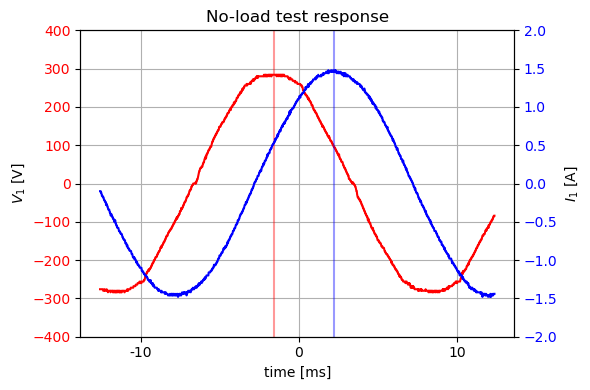

In [133]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.set_title("No-load test response")
ax1.set_xticks(np.arange(-0.02, 0.03, 0.01))
ax1.set_xticklabels(np.arange(-20, 30, 10))
ax1.grid(visible=True, which="both", axis="both")
ax1.set_ylim(-400, 400)
ax1.plot(df_short["t"], df_short["V1"], label="$V_1$", c="red")
ax1.set_xlabel("time [ms]")
ax1.set_ylabel("$V_1$ [V]")
ax1.tick_params(axis="y", labelcolor="red")
ax1.axvline(-1.6e-3, alpha=0.4, c="red", label=f"vert")
ax1.axvline(2.2e-3, alpha=0.4, c="blue", label=f"vert")
ax2 = ax1.twinx()
ax2.set_ylim(-2, 2)
ax2.plot(df_short["t"], df_short["I1"], label="I1", c="blue")
ax2.set_ylabel("$I_1$ [A]")
ax2.tick_params(axis="y", labelcolor="blue")
fig.tight_layout()
